# MELI EXCERCISE
## Description 
En el contexto de MercadoPago, se quiere desarrollar un modelo de Machine Learning para predecir el orden de un conjunto de Propuestas de Valor (aka, Value Props) en el carrusel de la app llamado “Descubrí Más”.

La tarea consiste en construir utilizando Python y sus librerías un pipeline que tenga como input 3 fuentes de datos diferentes y genere como resultado un dataset listo para ser ingerido por el modelo. 

## Data Sources
1. Prints (prints.json) - historial de 1 mes de value props que fueron mostradas a cada usuario, en formato json lines (un json por línea).

2. Taps (taps.json) - historial de 1 mes de value props que fueron clickeadas por un usuario, en formato json lines.

3. Payments (pays.csv) - historial de 1 mes de pagos realizados por los usuarios, en formato csv.

## Expected Result 
El dataset a construir deberá contar con la siguiente información: 

1. prints de la última semana 

2. por cada print: 
    - un campo que indique si se hizo click o no 
    - cantidad de veces que el usuario vio cada value prop en las 3 semanas previas a ese print. 
    - cantidad de veces que el usuario clickeo cada value prop en las 3 semanas previas a ese print.
    - cantidad de pagos que el usuario realizó para cada value prop en las 3 semanas previas a ese print.
    - importes acumulados que el usuario gasto para cada value prop en las 3 semanas previas a ese print.
## Deliverables 

1. Código Python 

2. Un Doc con una breve descripción de las decisiones tomadas.

In [78]:
# Unzipping all files from .zip file into /tmp folder
import os
import zipfile
with zipfile.ZipFile(
    f"{os.getcwd()}/data/CodeEx.zip", "r"
) as zip_ref:
    zip_ref.extractall(f"{os.getcwd()}/tmp/")

# PRINTS DATA EDA

In [79]:
# Reading inputs and unnested interesting values
import os
import pandas as pd # type: ignore

# Reading prints.json and first inspect
df_prints = pd.read_json(
    f"{os.getcwd()}/tmp/CodeEx/prints.json",
    lines=True
)
print(
    f"Numbers of rows of prints.json like dataframe: {len(df_prints)}"
)
print(f"Printing first 10 rows of prints")
print(df_prints.head(n=10))
print(
    f"Printing the first values of event_data column: {df_prints.event_data[0]}"
)

# Transforming all data to dataframe
print()
print()
print(
    f"Defining two new columns from even_data column and droping event_data"
)
df_prints["position"] = df_prints.event_data.str.get("position")
df_prints["value_prop"] = df_prints.event_data.str.get("value_prop")
df_prints_unnested = df_prints.drop("event_data", axis=1)
print(f"Printing first 10 rows of transformed prints")
print(df_prints_unnested.head(n=10))

# Count of prints by day and value_prop
print()
print()
df_prints_count = df_prints_unnested.groupby(
    ["day", "value_prop"]
).count().reset_index()
df_prints_count["day"] = pd.to_datetime(df_prints_count['day'])
df_prints_count["count"] = df_prints_count["user_id"]
df_prints_count = df_prints_count.drop(["user_id", "position"], axis=1)
print("Printing df_prints_count by day and value_prop")
print(df_prints_count.head(n=10))

Numbers of rows of prints.json like dataframe: 508617
Printing first 10 rows of prints
          day                                         event_data  user_id
0  2020-11-01  {'position': 0, 'value_prop': 'cellphone_recha...    98702
1  2020-11-01           {'position': 1, 'value_prop': 'prepaid'}    98702
2  2020-11-01           {'position': 0, 'value_prop': 'prepaid'}    63252
3  2020-11-01  {'position': 0, 'value_prop': 'cellphone_recha...    24728
4  2020-11-01        {'position': 1, 'value_prop': 'link_cobro'}    24728
5  2020-11-01  {'position': 2, 'value_prop': 'credits_consumer'}    24728
6  2020-11-01             {'position': 3, 'value_prop': 'point'}    24728
7  2020-11-01             {'position': 0, 'value_prop': 'point'}    25517
8  2020-11-01  {'position': 1, 'value_prop': 'credits_consumer'}    25517
9  2020-11-01         {'position': 2, 'value_prop': 'transport'}    25517
Printing the first values of event_data column: {'position': 0, 'value_prop': 'cellphone_recharge'}

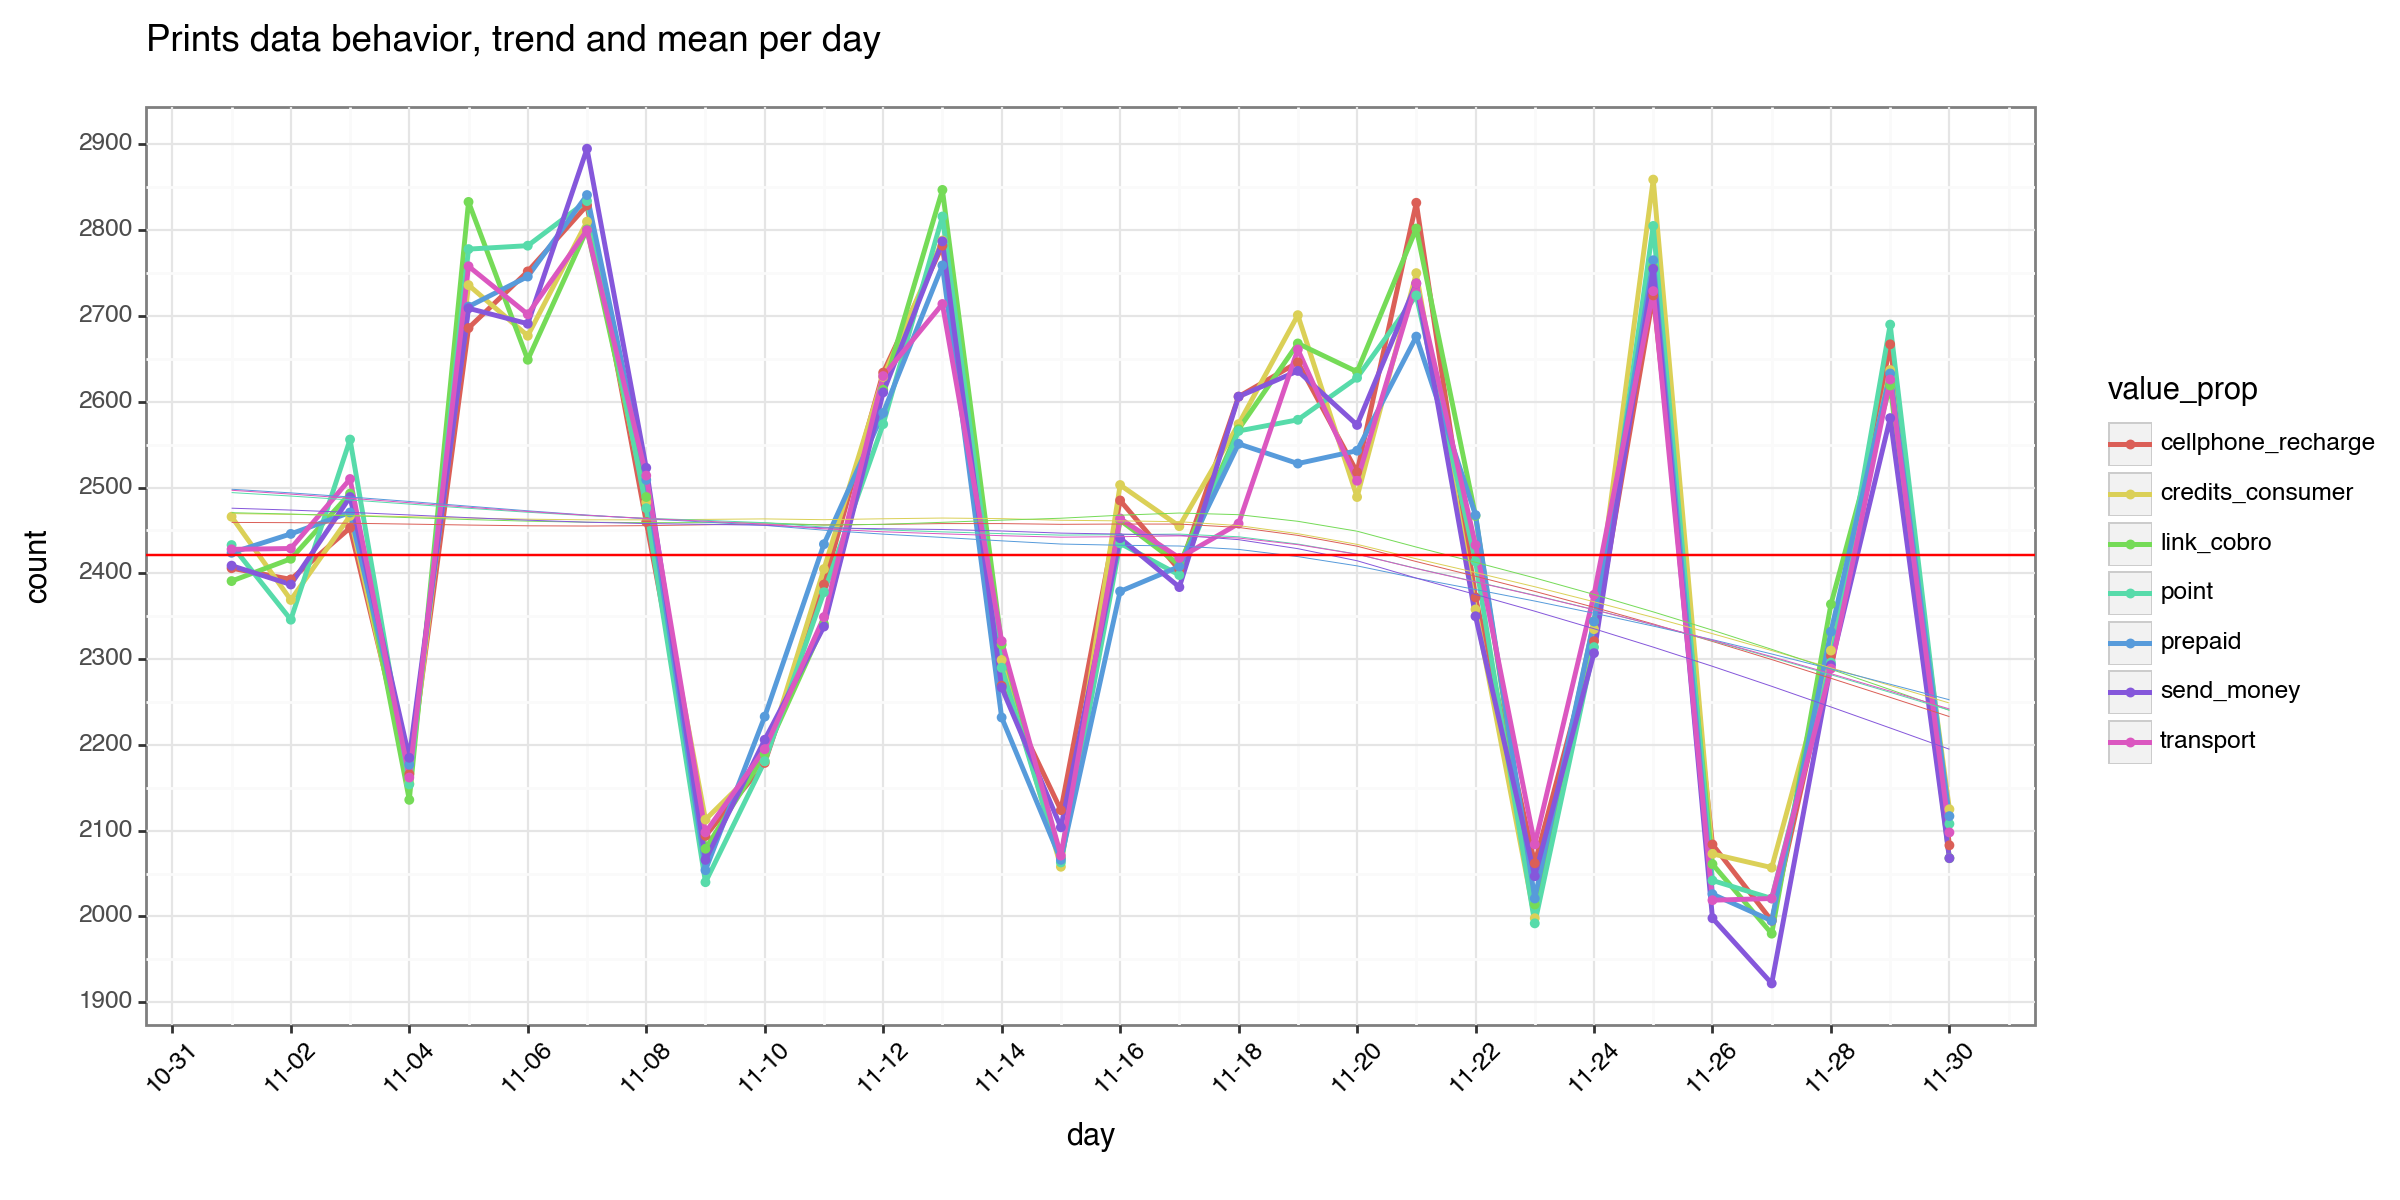

<Figure Size: (1200 x 600)>

In [80]:
# Plotting Time Series with ggplot to get more information about the data
import numpy as np
from plotnine import ( # type: ignore
    ggplot, aes, geom_line, 
    theme, element_text, scale_x_datetime,
    theme_bw, geom_smooth, geom_point, 
    ggtitle, scale_y_continuous, geom_hline
)

# ggplot
(
    ggplot(df_prints_count)
    + aes(x="day", y="count", color="value_prop")
    + geom_line(size=1)
    + geom_point(size=1)
    + geom_smooth(se=False, size=0.2)
    + geom_hline(
        yintercept=df_prints_count["count"].mean(),
        color="red"
    )
    + scale_y_continuous(
        breaks=np.linspace(start=0, stop=3000, num=31)
    )
    + scale_x_datetime(
        date_breaks = "2 day", date_labels="%m-%d"
    )
    + ggtitle(
        title="Prints data behavior, trend and mean per day"
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(
            colour="black", face="bold", angle=45, hjust=0.5
        ),
        figure_size=(12, 6)
    )
)

### Analysis of graphic
From this graph, the following information can be obtained from the Prints data related to the period studied (November 2020):
- There are 7 categories of value_prop
- Daily ranges are between 1900 and 2900 prints per category
- The total average (without discriminating category) of prints in this period is ~2422 prints per day per category.
- All categories of value_prop has similar behavior to each other.
- From November 18th onwards a tendency to decrease prints in all value_props begins, going down of the mean.
- It is a short analysis period to determine weekly, monthly or seasonal behavior of the data, etc. In this case, stochastic behavior is seen, but this assumption may be affected by the time window available for the analysis.

In [81]:
# Count of prints by position and value_prop
print()
print()
df_prints_count_2 = df_prints_unnested.groupby(
    ["position", "value_prop"]
).count().reset_index()
df_prints_count_2["count"] = df_prints_count_2["user_id"]
df_prints_count_2['position'] = df_prints_count_2['position'].astype(object)
df_prints_count_2 = df_prints_count_2.drop(["day", "user_id"], axis=1)
print("Printing df_prints_count_2 by position and value_prop")
print(df_prints_count_2.head(n=10))



Printing df_prints_count_2 by position and value_prop
  position          value_prop  count
0        0  cellphone_recharge  29293
1        0    credits_consumer  29097
2        0          link_cobro  29015
3        0               point  29075
4        0             prepaid  29091
5        0          send_money  28880
6        0           transport  29152
7        1  cellphone_recharge  21869
8        1    credits_consumer  21909
9        1          link_cobro  21884


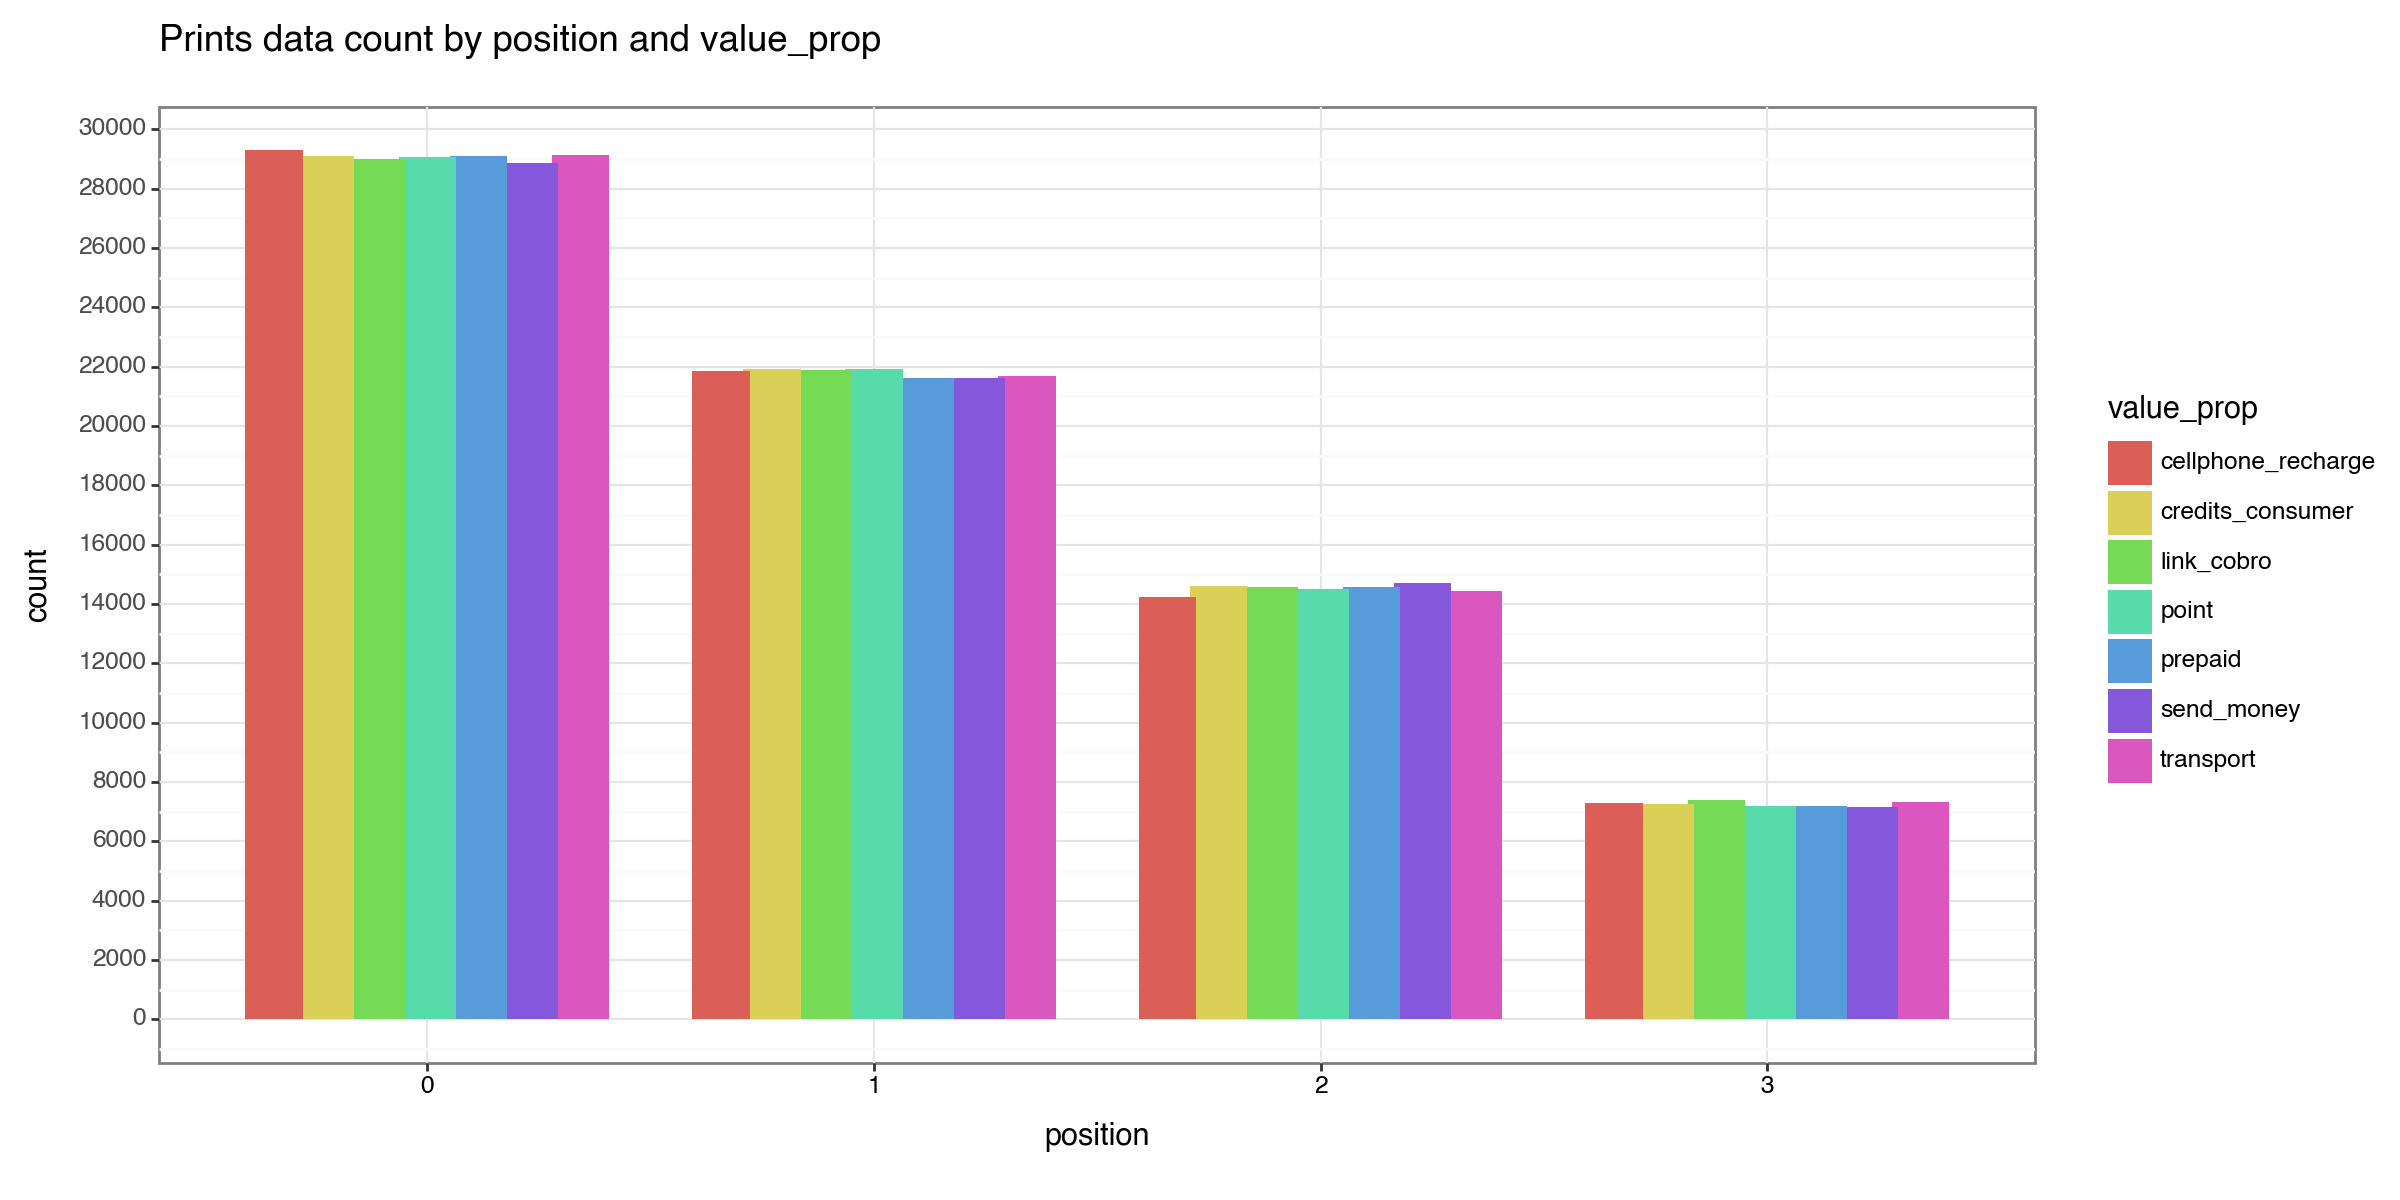

<Figure Size: (1200 x 600)>

In [82]:
# Plotting Barplot with ggplot to get more information about the data
from plotnine import ( # type: ignore
    ggplot, aes, 
    theme, element_text, scale_x_discrete,
    theme_bw, geom_bar, 
    ggtitle, scale_y_continuous, position_dodge
)

# ggplot
(
    ggplot(df_prints_count_2)
    + aes(x="position", y="count", fill="value_prop")
    + geom_bar(stat="identity", position = position_dodge(width = 0.8))
    + scale_y_continuous(
        breaks=np.linspace(start=0, stop=40000, num=21)
    )
    + scale_x_discrete()
    + ggtitle(
        title="Prints data count by position and value_prop"
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(
            colour="black", face="bold"
        ),
        figure_size=(12, 6)
    )
)

### Analysis of graphic
From this graph, the following information can be obtained from the Prints data related to the period studied (November 2020):
- The 7 categories, as in the temporal analysis, have similar behavior as they are separated by the position parameter
- The prints within November 2020 were between ~6000 and ~30000 in total for each category, depending on what position they had
- The positions have a direct relationship with the number of prints regardless of the category to which they belong (value_prop)
- Approximately within this month the prints decreased by 7000 from position to position, that is, those who were with position 0 had ~28000 prints, while those who were with position 1 had ~21000 prints.

# TAPS DATA EDA

In [83]:
# Reading inputs and unnested interesting values
import os
import pandas as pd # type: ignore

# Reading taps.json and first inspect
df_taps = pd.read_json(
    f"{os.getcwd()}/tmp/CodeEx/taps.json",
    lines=True
)
print(
    f"Numbers of rows of taps.json like dataframe: {len(df_taps)}"
)
print(f"Printing first 10 rows of taps")
print(df_taps.head(n=10))
print(
    f"Printing the first values of event_data column: {df_taps.event_data[0]}"
)
# Transforming all data to dataframe
print()
print()
print(
    f"Defining two new columns from even_data column and droping event_data"
)
df_taps["position"] = df_taps.event_data.str.get("position")
df_taps["value_prop"] = df_taps.event_data.str.get("value_prop")
df_taps_unnested = df_taps.drop("event_data", axis=1)
print(f"Printing first 10 rows of transformed prints")
print(df_taps_unnested.head(n=10))

# Count of prints by day and value_prop
print()
print()
df_taps_count = df_taps_unnested.groupby(
    ["day", "value_prop"]
).count().reset_index()
df_taps_count["day"] = pd.to_datetime(df_taps_count['day'])
df_taps_count["count"] = df_taps_count["user_id"]
df_taps_count = df_taps_count.drop(["user_id", "position"], axis=1)
print("Printing df_taps_count by day and value_prop")
print(df_taps_count.head(n=10))

Numbers of rows of taps.json like dataframe: 50859
Printing first 10 rows of taps
          day                                         event_data  user_id
0  2020-11-01  {'position': 0, 'value_prop': 'cellphone_recha...    98702
1  2020-11-01             {'position': 2, 'value_prop': 'point'}     3708
2  2020-11-01        {'position': 3, 'value_prop': 'send_money'}     3708
3  2020-11-01         {'position': 0, 'value_prop': 'transport'}    93963
4  2020-11-01  {'position': 1, 'value_prop': 'cellphone_recha...    93963
5  2020-11-01        {'position': 0, 'value_prop': 'link_cobro'}    94945
6  2020-11-01  {'position': 1, 'value_prop': 'cellphone_recha...    94945
7  2020-11-01           {'position': 2, 'value_prop': 'prepaid'}    89026
8  2020-11-01        {'position': 0, 'value_prop': 'link_cobro'}     7616
9  2020-11-01        {'position': 0, 'value_prop': 'link_cobro'}    63471
Printing the first values of event_data column: {'position': 0, 'value_prop': 'cellphone_recharge'}


De

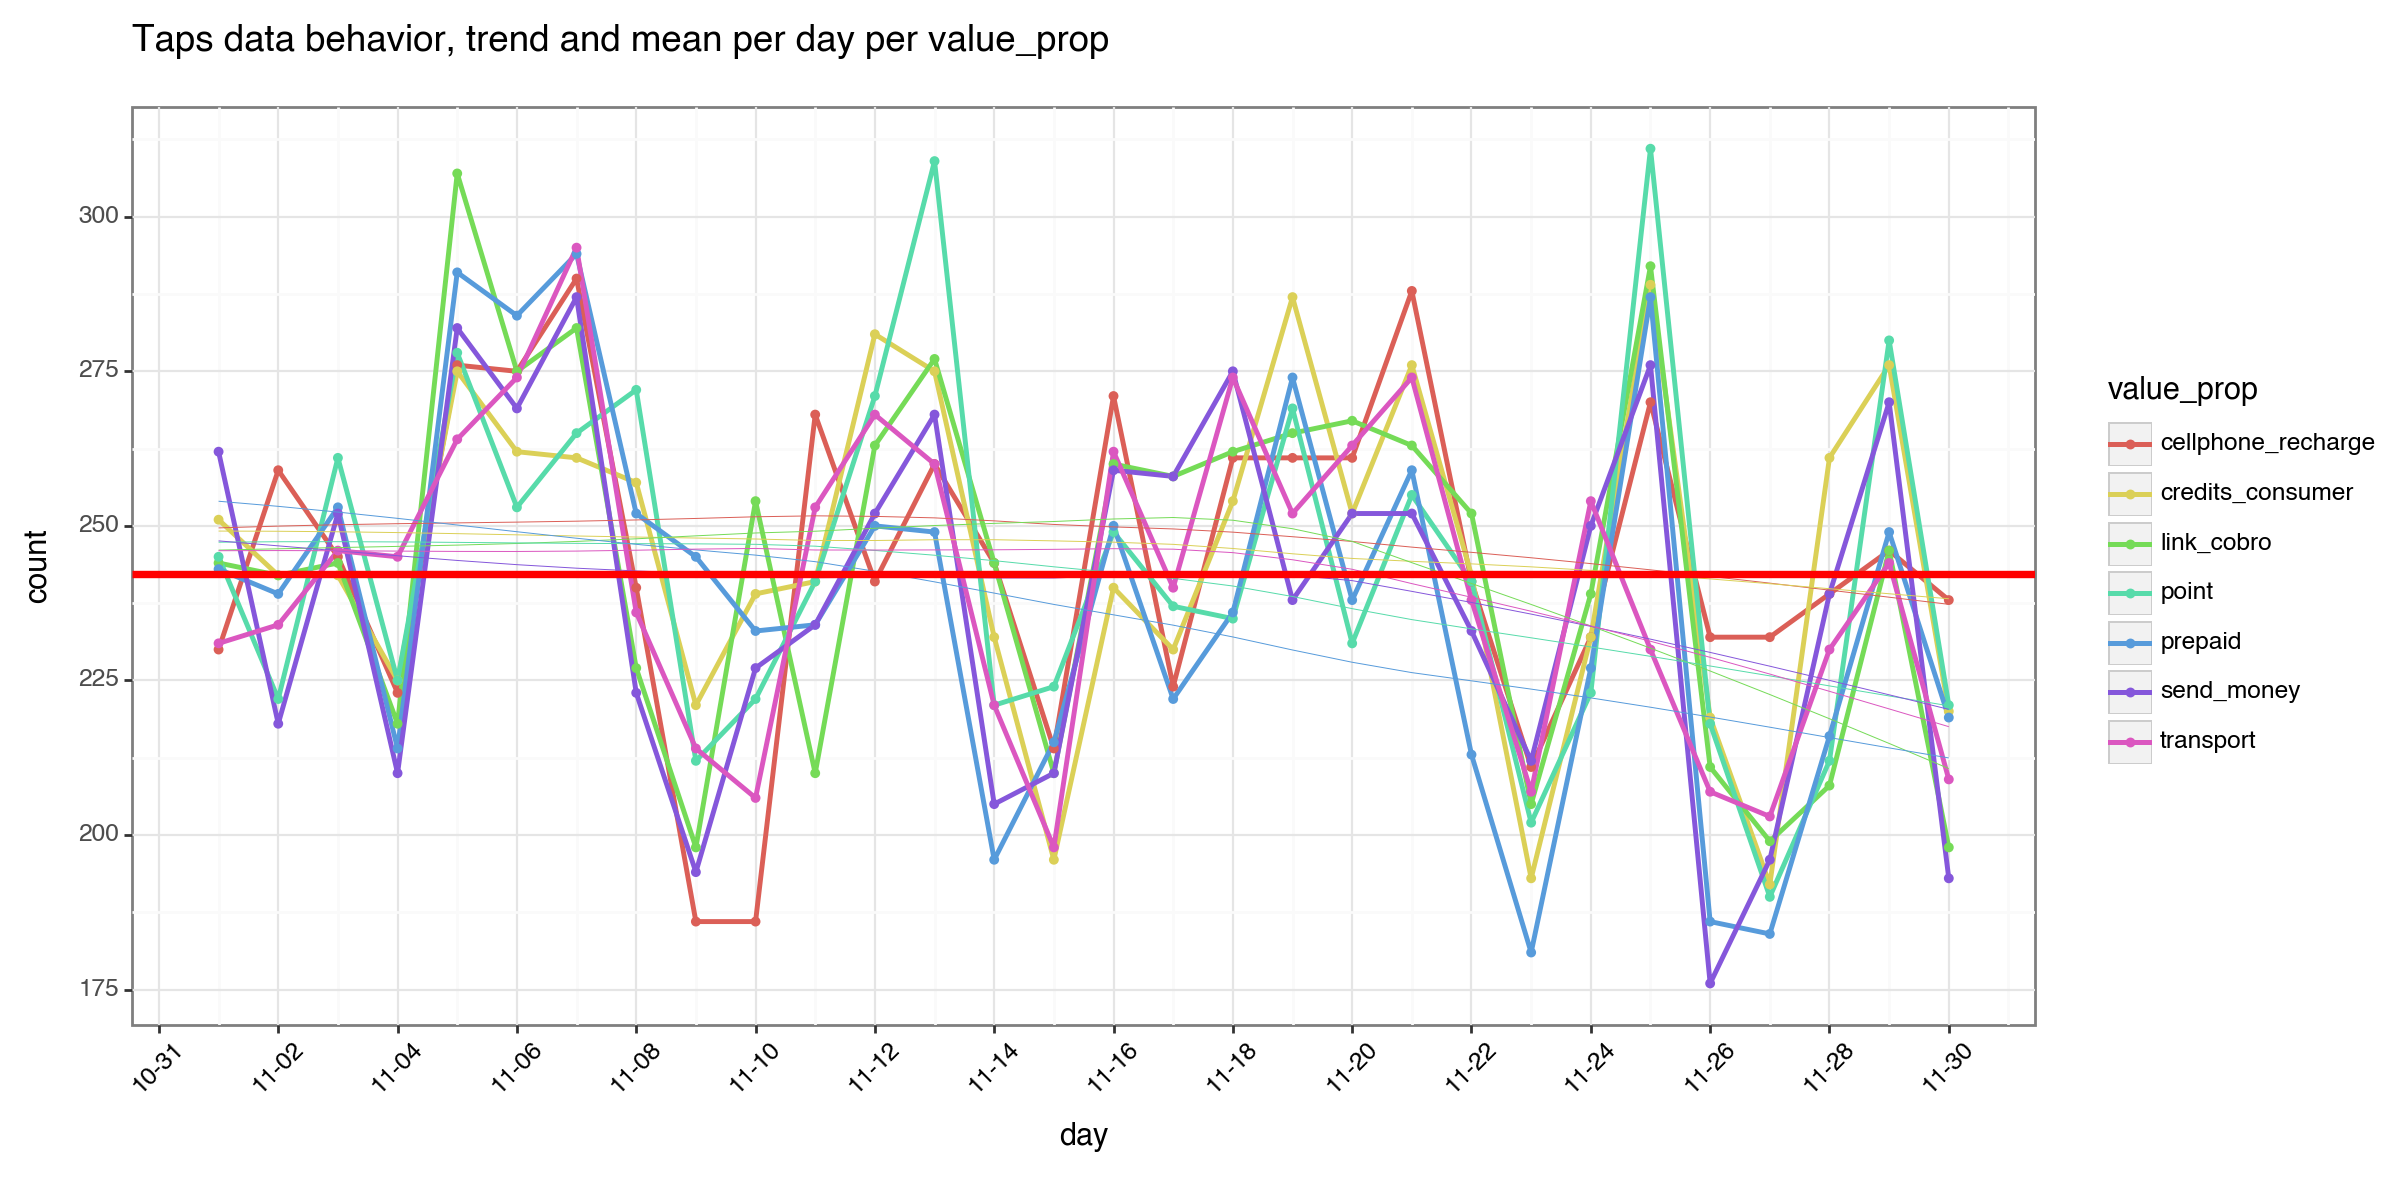

<Figure Size: (1200 x 600)>

In [84]:
# Plotting Time Series with ggplot to get more information about the data
import numpy as np
from plotnine import ( # type: ignore
    ggplot, aes, geom_line, 
    theme, element_text, scale_x_datetime,
    theme_bw, geom_smooth, geom_point, 
    ggtitle, scale_y_continuous, geom_hline
)

# ggplot
(
    ggplot(df_taps_count)
    + aes(x="day", y="count", color="value_prop")
    + geom_line(size=1)
    + geom_point(size=1)
    + geom_smooth(se=False, size=0.2)
    + geom_hline(
        yintercept=df_taps_count["count"].mean(),
        color="red",
        size=1.5
    )
    + scale_y_continuous(
        breaks=np.linspace(start=0, stop=500, num=21)
    )
    + scale_x_datetime(
        date_breaks = "2 day", date_labels="%m-%d"
    )
    + ggtitle(
        title="Taps data behavior, trend and mean per day per value_prop"
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(
            colour="black", face="bold", angle=45, hjust=0.5
        ),
        figure_size=(12, 6)
    )
)

### Analysis of graphic
From this graph, the following information can be obtained from the Taps data related to the period studied (November 2020):
- There are 7 categories of value_prop
- Daily ranges are between 175 and 325 taps per value_prop per day
- The total average (without discriminating category) of taps in this period is ~242 taps per day per category.
- All categories of value_prop has similar behavior to each other, however, in this case compared to prints, there is less similarity in the behavior of taps by value_prop.
- From November 18th onwards a tendency to decrease taps in all value_props begins, going down of the mean.
- It is a short analysis period to determine weekly, monthly or seasonal behavior of the data, etc. In this case, stochastic behavior is seen, but this assumption may be affected by the time window available for the analysis.

In [85]:
# Count of taps by position and value_prop
print()
print()
df_taps_count_2 = df_taps_unnested.groupby(
    ["position", "value_prop"]
).count().reset_index()
df_taps_count_2["count"] = df_taps_count_2["user_id"]
df_taps_count_2['position'] = df_taps_count_2['position'].astype(object)
df_taps_count_2 = df_taps_count_2.drop(["day", "user_id"], axis=1)
print("Printing df_taps_count_2 by position and value_prop")
print(df_taps_count_2.head(n=10))



Printing df_taps_count_2 by position and value_prop
  position          value_prop  count
0        0  cellphone_recharge   2981
1        0    credits_consumer   2944
2        0          link_cobro   2875
3        0               point   2948
4        0             prepaid   2833
5        0          send_money   2818
6        0           transport   2886
7        1  cellphone_recharge   2203
8        1    credits_consumer   2161
9        1          link_cobro   2215


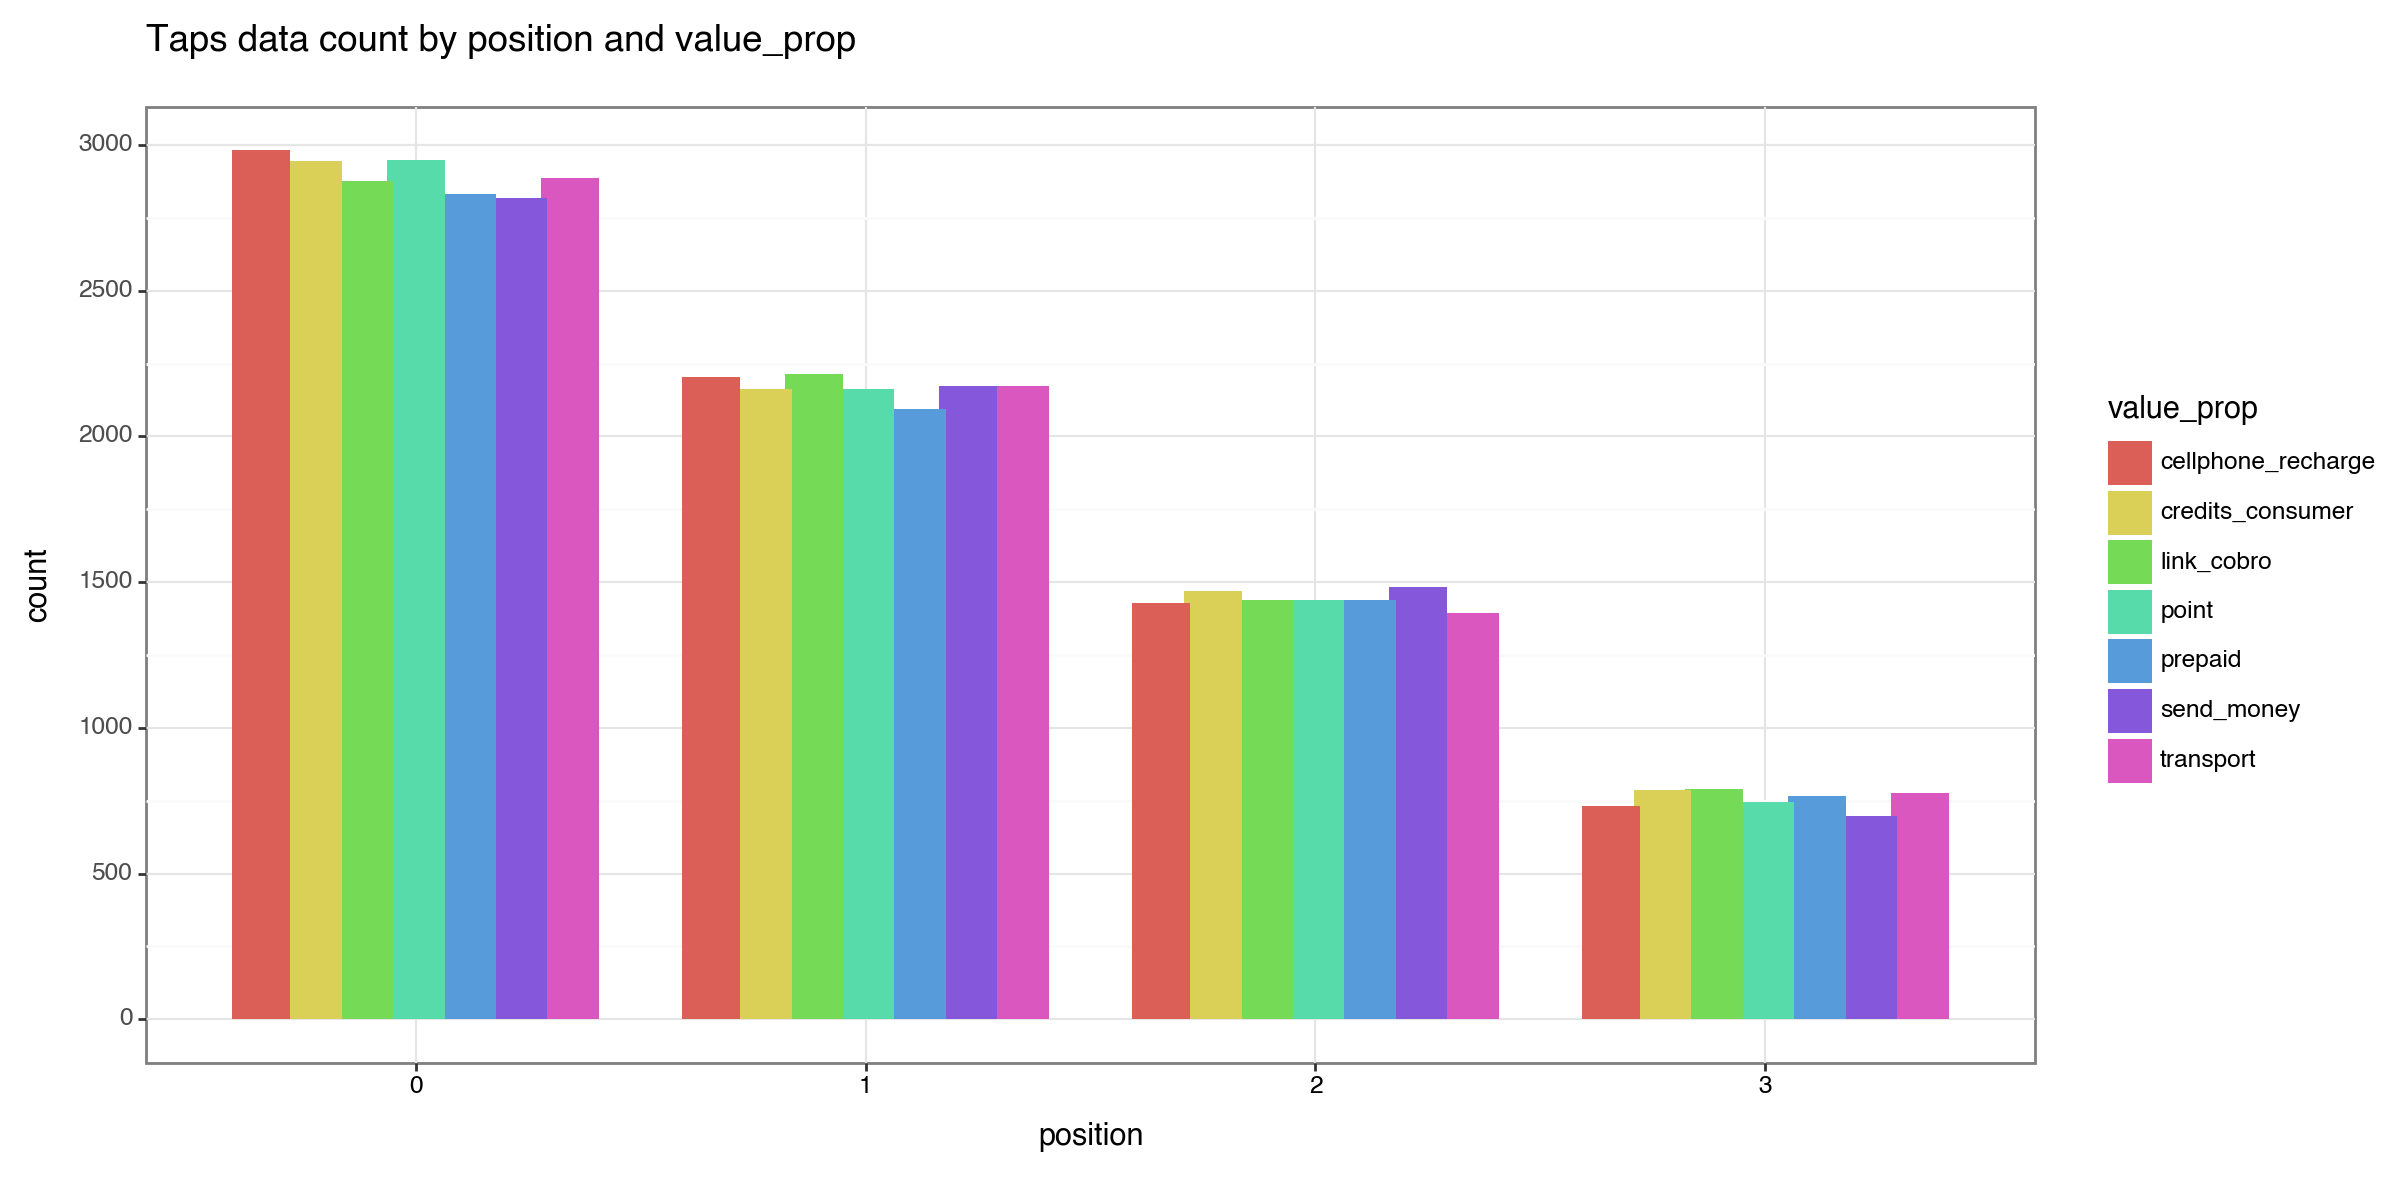

<Figure Size: (1200 x 600)>

In [86]:
# Plotting Barplot with ggplot to get more information about the data
from plotnine import ( # type: ignore
    ggplot, aes, 
    theme, element_text, scale_x_discrete,
    theme_bw, geom_bar, 
    ggtitle, scale_y_continuous, position_dodge
)

# ggplot
(
    ggplot(df_taps_count_2)
    + aes(x="position", y="count", fill="value_prop")
    + geom_bar(stat="identity", position = position_dodge(width = 0.8))
    + scale_y_continuous(
        breaks=np.linspace(start=0, stop=10000, num=21)
    )
    + scale_x_discrete()
    + ggtitle(
        title="Taps data count by position and value_prop"
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(
            colour="black", face="bold"
        ),
        figure_size=(12, 6)
    )
)

### Analysis of graphic
From this graph, the following information can be obtained from the Taps data related to the period studied (November 2020):
- The 7 categories, as in the temporal analysis, have similar behavior as they are separated by the position parameter
- The taps within November 2020 were between ~750 and ~3000 in total for each category, depending on what position they had
- The positions have a direct relationship with the number of taps regardless of the category to which they belong (value_prop)
- Approximately within this month the taps decreased by 750 from position to position, that is, those who were with position 0 had ~3000 taps, while those who were with position 1 had ~2250 prints.

# PAYS DATA EDA

In [87]:
# Reading input
import os
import pandas as pd # type: ignore

# Reading pays.csv and first inspect
df_pays = pd.read_csv(
    f"{os.getcwd()}/tmp/CodeEx/pays.csv"
)
print(
    f"Numbers of rows of pays.csv dataframe: {len(df_pays)}"
)
print(f"Printing first 10 rows of pays")
print(df_pays.head(n=10))
# Count of prints by day and value_prop
print()
print()
df_pays_count = df_pays.groupby(
    ["pay_date", "value_prop"]
).count().reset_index()
df_pays_count["pay_date"] = pd.to_datetime(df_pays_count['pay_date'])
df_pays_count["count"] = df_pays_count["user_id"]
df_pays_count = df_pays_count.drop(["user_id", "total"], axis=1)
print("Printing df_pays_count by day and value_prop")
print(df_pays_count.head(n=10))

Numbers of rows of pays.csv dataframe: 756483
Printing first 10 rows of pays
     pay_date  total  user_id          value_prop
0  2020-11-01   7.04    35994          link_cobro
1  2020-11-01  37.36    79066  cellphone_recharge
2  2020-11-01  15.84    19321  cellphone_recharge
3  2020-11-01  26.26    19321          send_money
4  2020-11-01  35.35    38438          send_money
5  2020-11-01  20.95    85939           transport
6  2020-11-01  74.48    14372             prepaid
7  2020-11-01  31.52    14372          link_cobro
8  2020-11-01  83.76    65274           transport
9  2020-11-01  93.54    65274             prepaid


Printing df_pays_count by day and value_prop
    pay_date          value_prop  count
0 2020-11-01  cellphone_recharge   2786
1 2020-11-01    credits_consumer   2946
2 2020-11-01          link_cobro   2936
3 2020-11-01               point   2845
4 2020-11-01             prepaid   2823
5 2020-11-01          send_money   2775
6 2020-11-01           transport   2866
7 2020

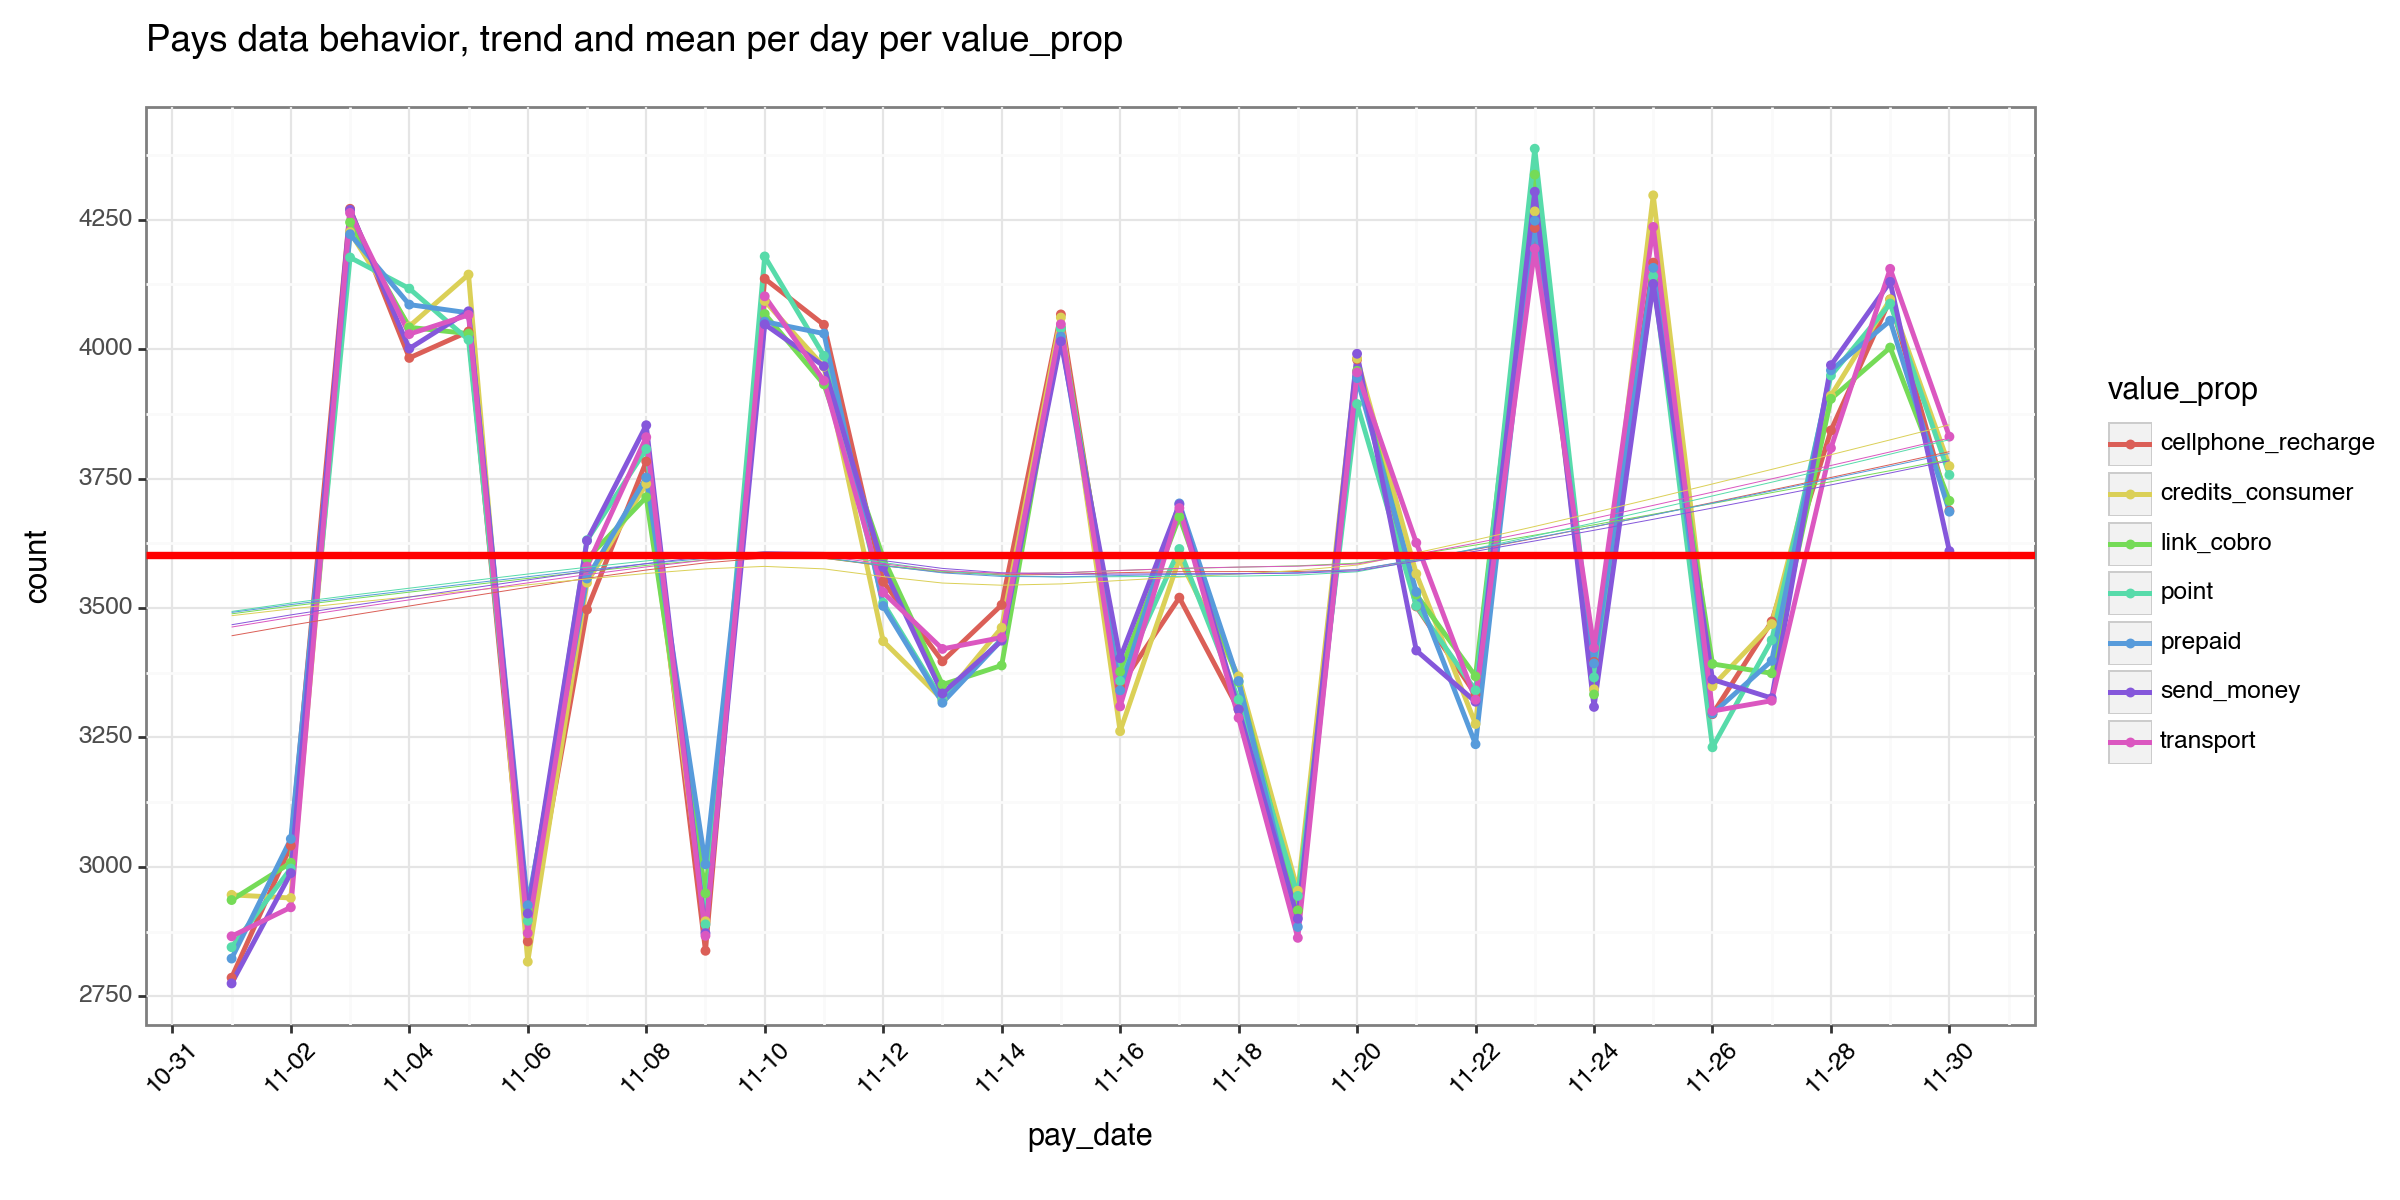

<Figure Size: (1200 x 600)>

In [88]:
# Plotting Time Series with ggplot to get more information about the data
import numpy as np
from plotnine import ( # type: ignore
    ggplot, aes, geom_line, 
    theme, element_text, scale_x_datetime,
    theme_bw, geom_smooth, geom_point, 
    ggtitle, scale_y_continuous, geom_hline
)

# ggplot
(
    ggplot(df_pays_count)
    + aes(x="pay_date", y="count", color="value_prop")
    + geom_line(size=1)
    + geom_point(size=1)
    + geom_smooth(se=False, size=0.2)
    + geom_hline(
        yintercept=df_pays_count["count"].mean(),
        color="red",
        size=1.5
    )
    + scale_y_continuous(
        breaks=np.linspace(start=0, stop=5000, num=21)
    )
    + scale_x_datetime(
        date_breaks = "2 day", date_labels="%m-%d"
    )
    + ggtitle(
        title="Pays data behavior, trend and mean per day per value_prop"
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(
            colour="black", face="bold", angle=45, hjust=0.5
        ),
        figure_size=(12, 6)
    )
)

### Analysis of graphic
From this graph, the following information can be obtained from the Pays data related to the period studied (November 2020):
- There are 7 categories of value_prop
- Daily ranges are between 2750 and 4375 pays per value_prop per day
- The total average (without discriminating category) of pays in this period is ~3602 pays per day per category.
- All categories of value_prop has similar behavior to each other.
- As of November 20, a trend has begun to increase the pays in all value_props, exceeding the average. This behavior is different from that seen in the prints and taps.
- It is a short analysis period to determine weekly, monthly or seasonal behavior of the data, etc. In this case, stochastic behavior is seen, but this assumption may be affected by the time window available for the analysis.

# ALL DATA EDA

In [89]:
# Merging all data by day and pay_date column
df_prints_total_count = df_prints_count.groupby(
    "day"
).sum(
).reset_index(
).drop(
    "value_prop", 
    axis=1
).rename(
    columns={"count": "total_prints"}
)

df_taps_total_count = df_taps_count.groupby(
    "day"
).sum(
).reset_index(
).drop(
    "value_prop", 
    axis=1
).rename(
    columns={"count": "total_taps"}
)

df_pays_total_count = df_pays_count.groupby(
    "pay_date"
).sum(
).reset_index(
).drop(
    "value_prop", 
    axis=1
).rename(
    columns={
        "count": "total_pays",
        "pay_date": "day"
    }
)

# Merging three source of counts by day
df_total_counts = df_prints_total_count.merge(
    df_taps_total_count, on="day", how="left"
).merge(
    df_pays_total_count, on="day", how="left"
)

# Wide to long table
df_long = pd.melt(df_total_counts, id_vars='day')


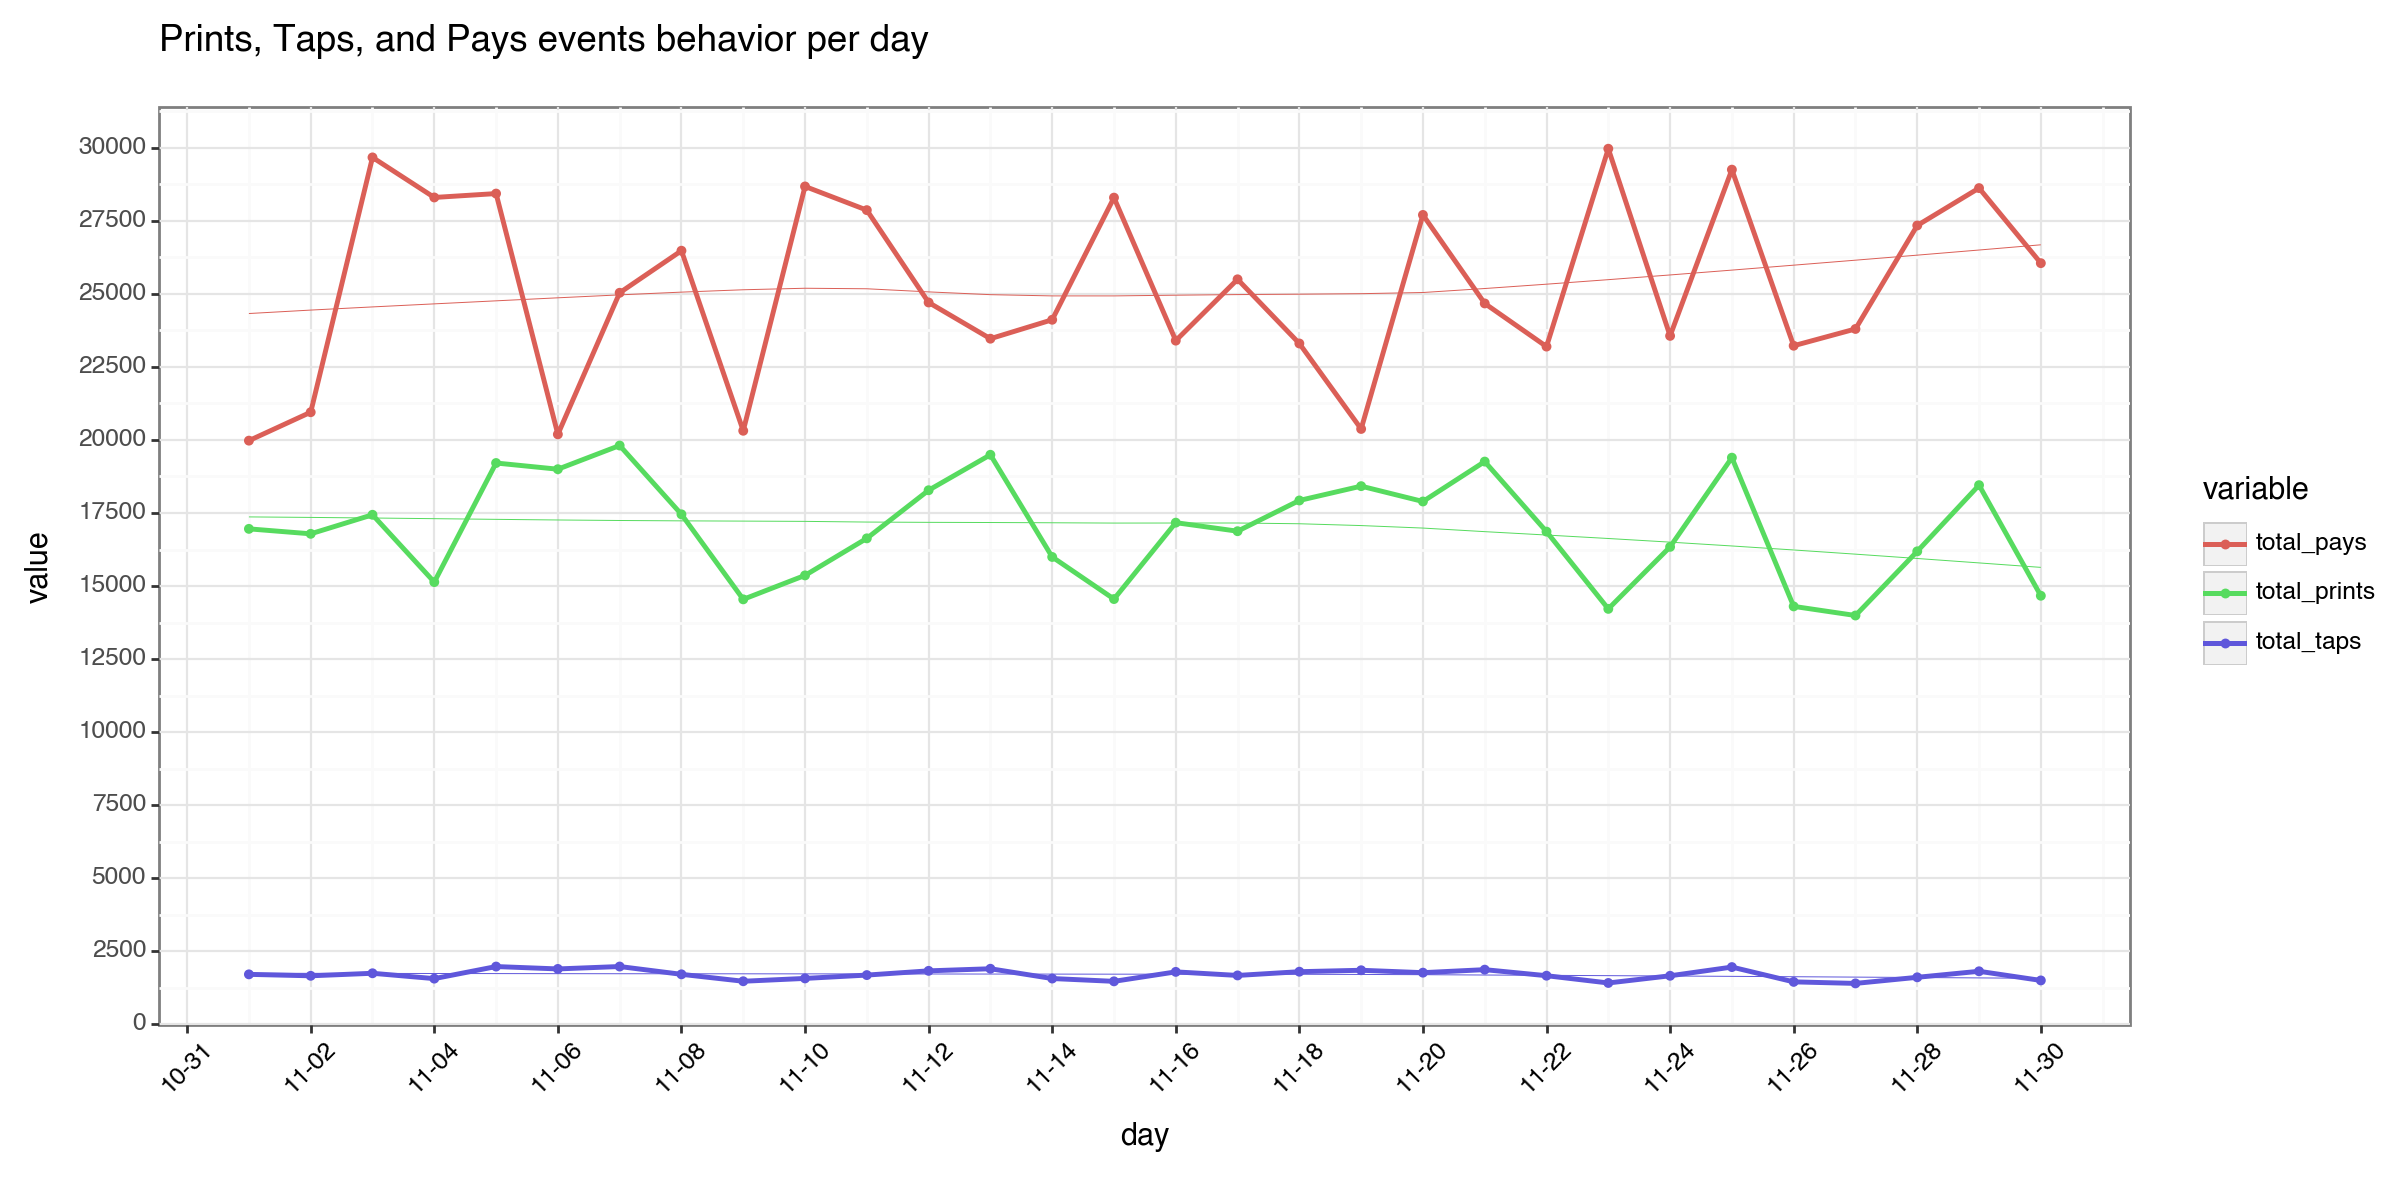

<Figure Size: (1200 x 600)>

In [90]:
# Plotting Time Series with ggplot to get more information about the data
import numpy as np
from plotnine import ( # type: ignore
    ggplot, aes, geom_line, 
    theme, element_text, scale_x_datetime,
    theme_bw, geom_smooth, geom_point, 
    ggtitle, scale_y_continuous, geom_hline
)

# ggplot
(
    ggplot(df_long)
    + aes(x="day", y="value", color="variable")
    + geom_line(size=1)
    + geom_point(size=1)
    + geom_smooth(se=False, size=0.2)
    + scale_y_continuous(
        breaks=np.linspace(start=0, stop=50000, num=21)
    )
    + scale_x_datetime(
        date_breaks = "2 day", date_labels="%m-%d"
    )
    + ggtitle(
        title="Prints, Taps, and Pays events behavior per day"
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(
            colour="black", face="bold", angle=45, hjust=0.5
        ),
        figure_size=(12, 6)
    )
)

In [91]:
corr = df_total_counts.drop(
    "day", axis=1
).corr()
corr.style.background_gradient(cmap='coolwarm')

,total_prints,total_taps,total_pays
total_prints,1.000000,0.985439,-0.068271
total_taps,0.985439,1.000000,-0.053861
total_pays,-0.068271,-0.053861,1.000000


In [92]:
df_pays_total_sum = df_pays.groupby(
    "pay_date"
).sum(
).reset_index(
).drop(
    [
        "user_id",
        "value_prop"
    ], 
    axis=1
).rename(
    columns={
        "total": "pays_sum_total/100",
        "pay_date": "day"
    }
)
df_pays_total_sum["day"] = pd.to_datetime(df_pays_total_sum['day'])
df_pays_total_sum["pays_sum_total/100"] = df_pays_total_sum['pays_sum_total/100']/100

# Merging three source of counts by day and total_sum
df_total_counts_and_sum = df_prints_total_count.merge(
    df_taps_total_count, on="day", how="left"
).merge(
    df_pays_total_count, on="day", how="left"
).merge(
    df_pays_total_sum, on="day", how="left"
)

# Wide to long table
df_long = pd.melt(df_total_counts_and_sum, id_vars='day')

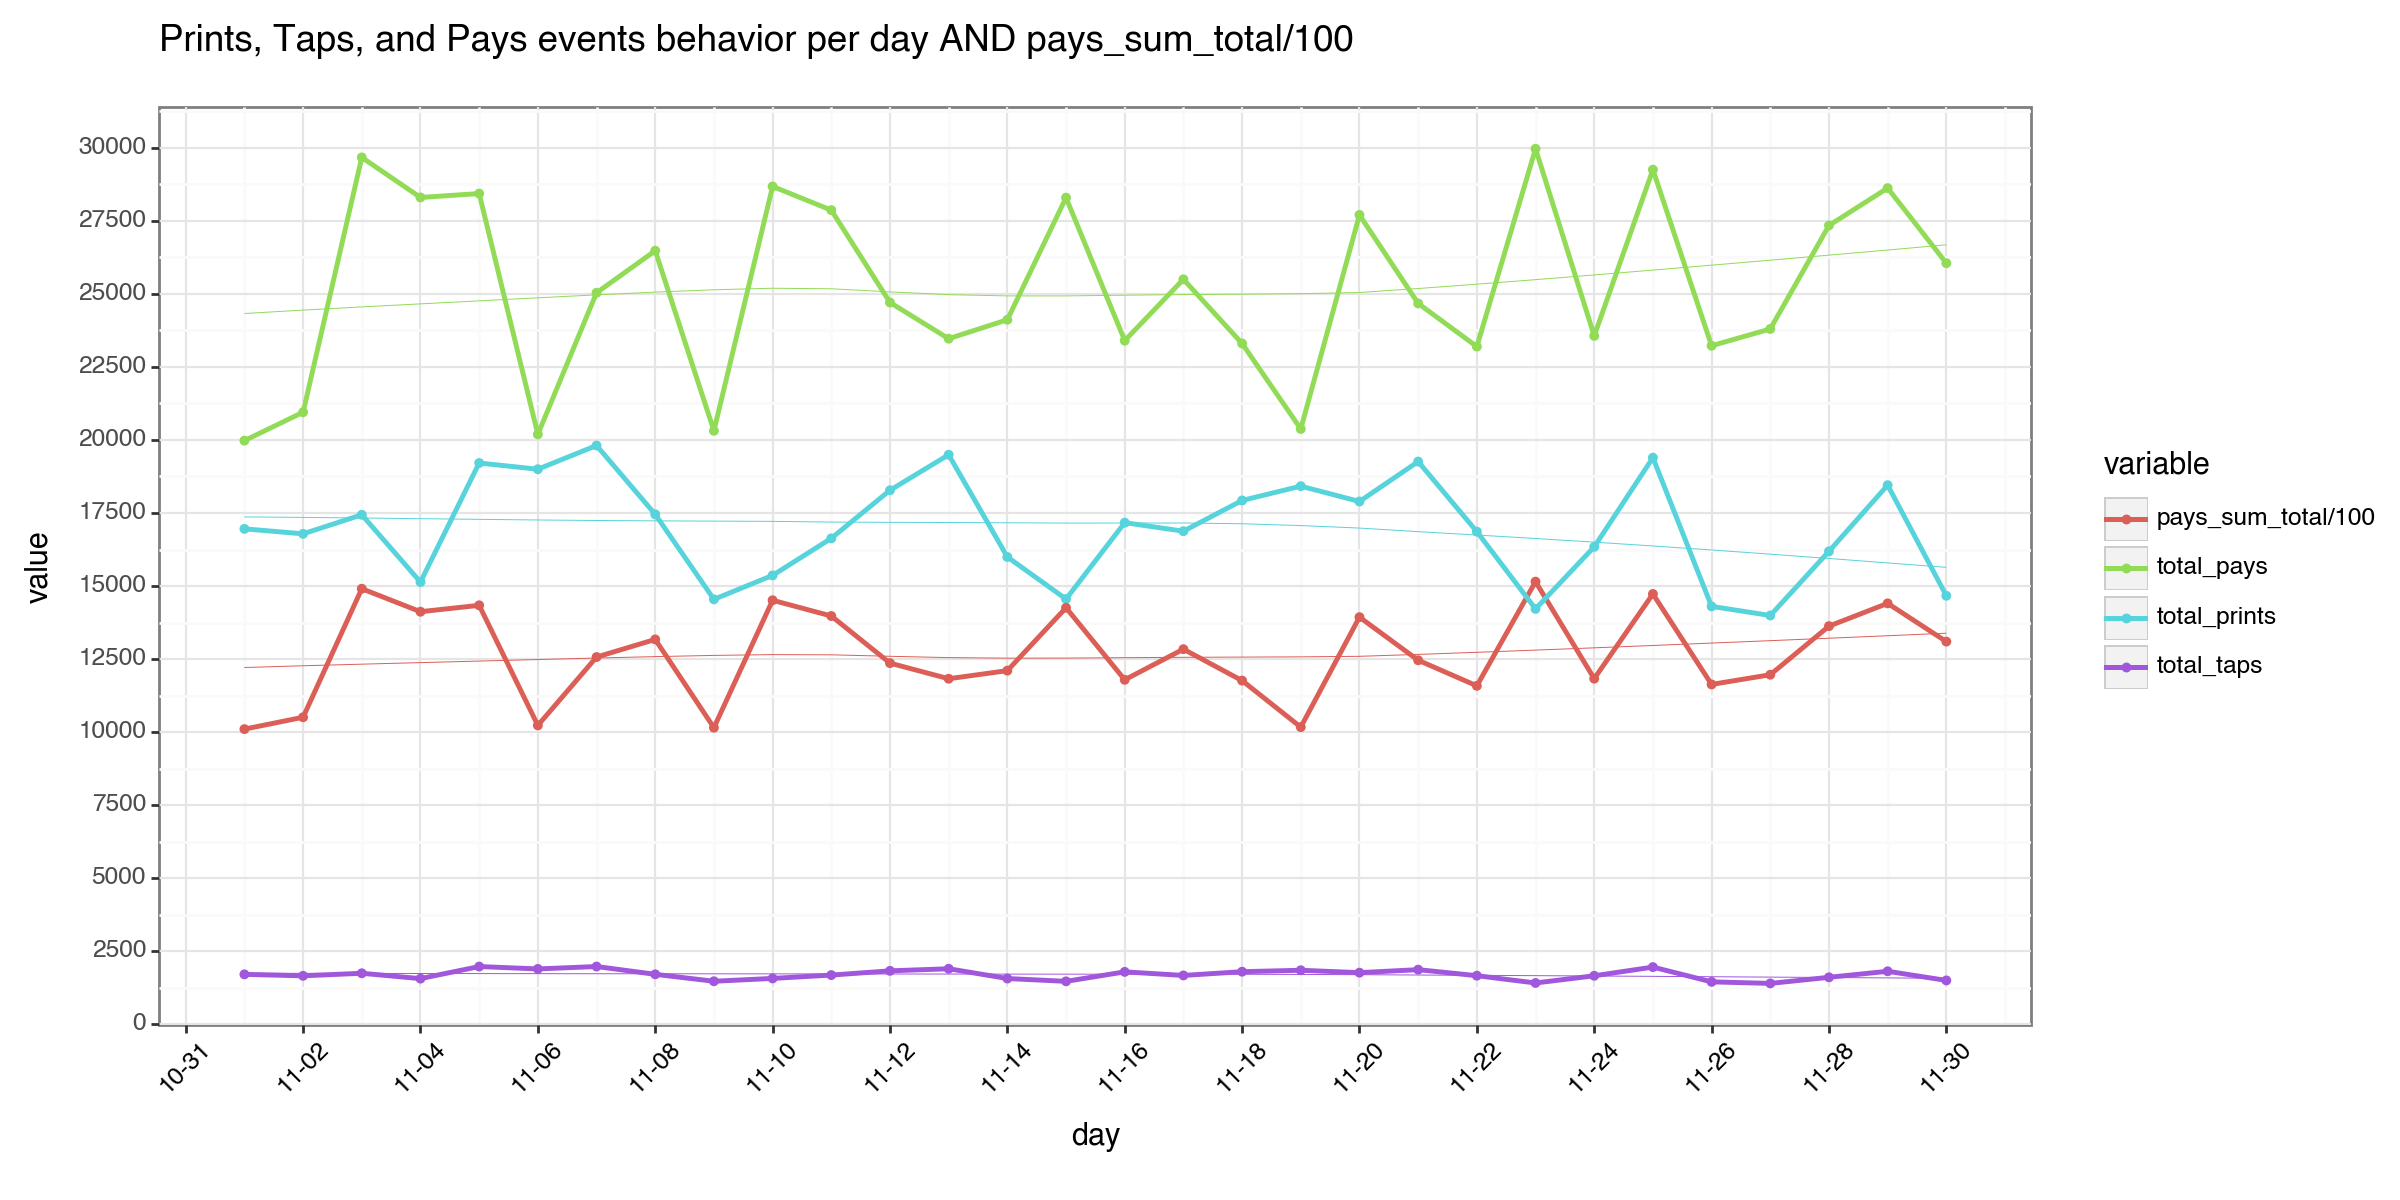

<Figure Size: (1200 x 600)>

In [93]:
# Plotting Time Series with ggplot to get more information about the data
import numpy as np
from plotnine import ( # type: ignore
    ggplot, aes, geom_line, 
    theme, element_text, scale_x_datetime,
    theme_bw, geom_smooth, geom_point, 
    ggtitle, scale_y_continuous, geom_hline
)

# ggplot
(
    ggplot(df_long)
    + aes(x="day", y="value", color="variable")
    + geom_line(size=1)
    + geom_point(size=1)
    + geom_smooth(se=False, size=0.2)
    + scale_y_continuous(
        breaks=np.linspace(start=0, stop=50000, num=21)
    )
    + scale_x_datetime(
        date_breaks = "2 day", date_labels="%m-%d"
    )
    + ggtitle(
        title="Prints, Taps, and Pays events behavior per day AND pays_sum_total/100"
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(
            colour="black", face="bold", angle=45, hjust=0.5
        ),
        figure_size=(12, 6)
    )
)

In [94]:
corr = df_total_counts_and_sum.drop(
    "day", axis=1
).corr()
corr.style.background_gradient(cmap='coolwarm')

,total_prints,total_taps,total_pays,pays_sum_total/100
total_prints,1.000000,0.985439,-0.068271,-0.062634
total_taps,0.985439,1.000000,-0.053861,-0.047593
total_pays,-0.068271,-0.053861,1.000000,0.999259
pays_sum_total/100,-0.062634,-0.047593,0.999259,1.000000


In [95]:
df_total_counts_and_sum_2 = df_total_counts_and_sum.sort_values('day')
for i in list(np.linspace(start=1, stop=20, num=20)):
    df_total_counts_and_sum_2[
        f"total_pays_lag_{int(i)}"
    ] = df_total_counts_and_sum_2['total_pays'].shift(int(i))
print(df_total_counts_and_sum_2.head(n=5))

corr = df_total_counts_and_sum_2.drop(
    "day", axis=1
).corr()
corr.style.background_gradient(cmap='coolwarm')


         day  total_prints  total_taps  total_pays  pays_sum_total/100  \
0 2020-11-01         16957        1706       19977          10101.2385   
1 2020-11-02         16787        1656       20950          10507.6365   
2 2020-11-03         17439        1743       29673          14907.9118   
3 2020-11-04         15135        1560       28302          14120.6382   
4 2020-11-05         19211        1973       28435          14339.2583   

   total_pays_lag_1  total_pays_lag_2  total_pays_lag_3  total_pays_lag_4  \
0               NaN               NaN               NaN               NaN   
1           19977.0               NaN               NaN               NaN   
2           20950.0           19977.0               NaN               NaN   
3           29673.0           20950.0           19977.0               NaN   
4           28302.0           29673.0           20950.0           19977.0   

   total_pays_lag_5  ...  total_pays_lag_11  total_pays_lag_12  \
0               NaN  ...  

,total_prints,total_taps,total_pays,pays_sum_total/100,total_pays_lag_1,total_pays_lag_2,total_pays_lag_3,total_pays_lag_4,total_pays_lag_5,total_pays_lag_6,total_pays_lag_7,total_pays_lag_8,total_pays_lag_9,total_pays_lag_10,total_pays_lag_11,total_pays_lag_12,total_pays_lag_13,total_pays_lag_14,total_pays_lag_15,total_pays_lag_16,total_pays_lag_17,total_pays_lag_18,total_pays_lag_19,total_pays_lag_20
total_prints,1.000000,0.985439,-0.068271,-0.062634,-0.064709,0.197368,0.043970,-0.067085,-0.207821,-0.231818,-0.196898,0.427842,0.376497,0.033214,-0.178489,-0.462512,0.039029,0.496227,-0.063239,-0.190292,0.231409,0.062720,-0.483700,-0.298470
total_taps,0.985439,1.000000,-0.053861,-0.047593,-0.001928,0.221582,-0.012376,-0.096373,-0.191008,-0.233039,-0.182295,0.456173,0.341237,-0.036044,-0.171810,-0.422171,0.091842,0.481291,-0.056624,-0.203373,0.176141,-0.001838,-0.484030,-0.228750
total_pays,-0.068271,-0.053861,1.000000,0.999259,-0.139244,-0.222312,-0.055951,-0.221340,0.282863,-0.128578,0.167461,0.173592,-0.405246,0.111450,-0.226215,0.225078,0.203891,-0.362937,0.110706,-0.307566,0.184701,0.411187,-0.268746,0.444764
pays_sum_total/100,-0.062634,-0.047593,0.999259,1.000000,-0.142586,-0.208578,-0.049847,-0.238637,0.270665,-0.112947,0.172779,0.167296,-0.406227,0.125135,-0.225998,0.220623,0.214961,-0.366062,0.106849,-0.307554,0.173594,0.407056,-0.261308,0.444240
total_pays_lag_1,-0.064709,-0.001928,-0.139244,-0.142586,1.000000,-0.151790,-0.229648,-0.052709,-0.216785,0.275889,-0.124335,0.159032,0.181416,-0.405153,0.101896,-0.215187,0.236197,0.202167,-0.359750,0.095602,-0.304961,0.193820,0.412985,-0.274135
total_pays_lag_2,0.197368,0.221582,-0.222312,-0.208578,-0.151790,1.000000,-0.188190,-0.219393,-0.027233,-0.301550,0.311501,-0.233506,0.196203,0.191426,-0.489330,0.216694,-0.186027,0.236658,0.255760,-0.475121,0.124346,-0.282716,0.215854,0.366629
total_pays_lag_3,0.043970,-0.012376,-0.055951,-0.049847,-0.229648,-0.188190,1.000000,-0.180005,-0.207255,-0.071381,-0.291691,0.270263,-0.218481,0.201448,0.159449,-0.463611,0.249970,-0.200019,0.274409,0.211867,-0.473625,0.161052,-0.284237,0.167995
total_pays_lag_4,-0.067085,-0.096373,-0.221340,-0.238637,-0.052709,-0.219393,-0.180005,1.000000,-0.192695,-0.186183,-0.081246,-0.277787,0.263477,-0.221051,0.230357,0.133961,-0.489721,0.256953,-0.217442,0.316287,0.205967,-0.498482,0.158846,-0.262771
total_pays_lag_5,-0.207821,-0.191008,0.282863,0.270665,-0.216785,-0.027233,-0.207255,-0.192695,1.000000,-0.163974,-0.203438,-0.034071,-0.298340,0.264356,-0.193899,0.190233,0.116131,-0.492677,0.239091,-0.179944,0.310700,0.186827,-0.516397,0.213839
total_pays_lag_6,-0.231818,-0.233039,-0.128578,-0.112947,0.275889,-0.301550,-0.071381,-0.186183,-0.163974,1.000000,-0.145445,-0.323189,-0.001211,-0.310592,0.211263,-0.094630,0.251138,0.110067,-0.483625,0.154336,-0.170086,0.407098,0.220745,-0.699160
